# Learn with Linear Model

Use a linear model to learn weights for draco. 

In [1]:
from draco.learn import linear
from draco.learn import data_util
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
data, _ = data_util.load_data(test_size=0.3)

## Run Model and then PCA

We see 7 distinct clusters. What do they mean?

Train score:  0.8210161662817552
Dev score:  0.8548387096774194


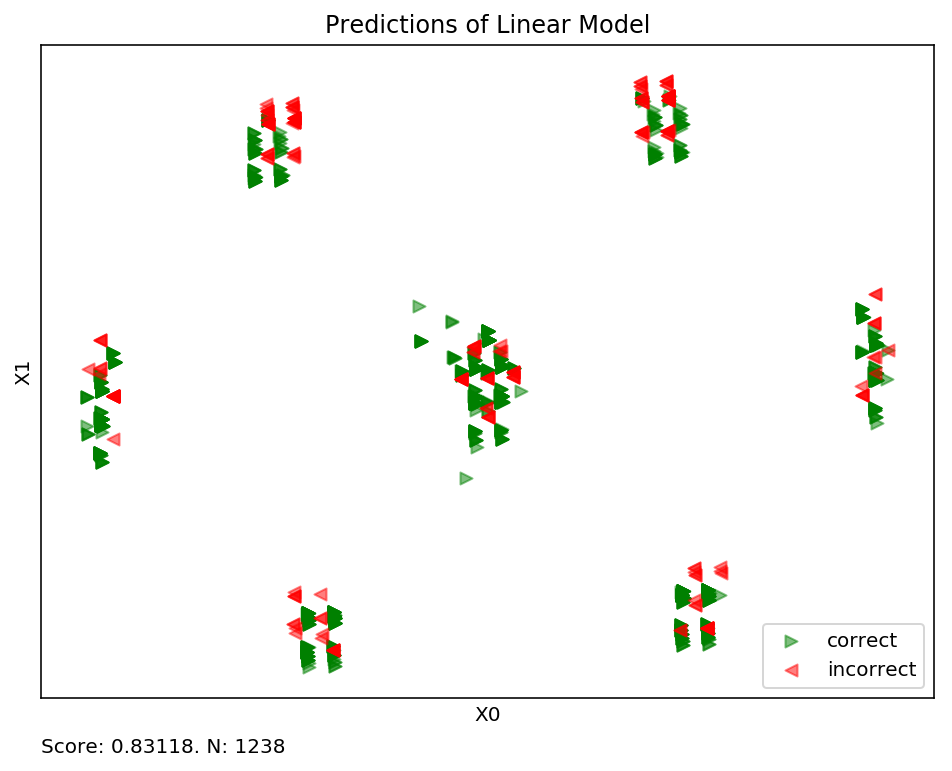

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=False,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

CPU times: user 879 ms, sys: 114 ms, total: 993 ms
Wall time: 771 ms


In [3]:
%time linear.train_and_plot(data, test_size=0.3)

## Explain Variance

Try to explain the variance using principal components. It we can explain most of the variance with few components, then the clustering we see above should be meaningful. 

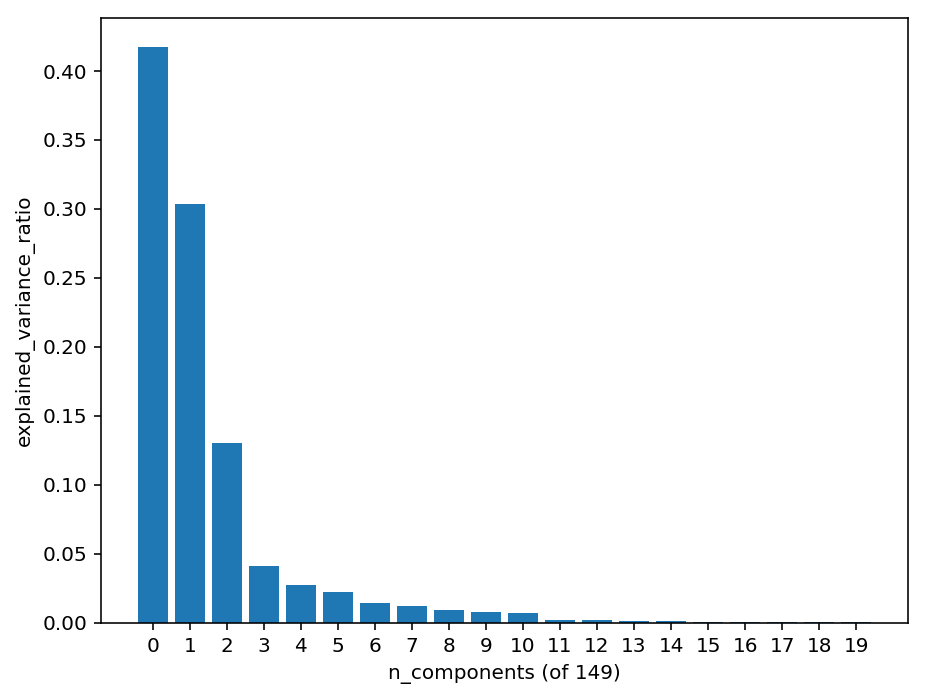

In [4]:
X = data.positive - data.negative

pca = PCA()
X2 = pca.fit_transform(X)

num_features = len(X.columns)
size = 20  # num_features

x = np.arange(size)

plt.figure(figsize=(8,6))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.bar(x=x, height=pca.explained_variance_ratio_[:size])
plt.axis('tight')
plt.xlabel(f'n_components (of {num_features})')
plt.ylabel('explained_variance_ratio')
plt.xticks(x)

plt.show()

## Model score to accuracy

In [5]:
clf = linear.train_model(X, 0.3)

Train score:  0.8210161662817552
Dev score:  0.8548387096774194


In [64]:
df = pd.DataFrame(columns=['pred', 'score'])
df.pred = clf.predict(X)
df.score = clf.decision_function(X)

df = df.sort_values('score')

df = df.reset_index();

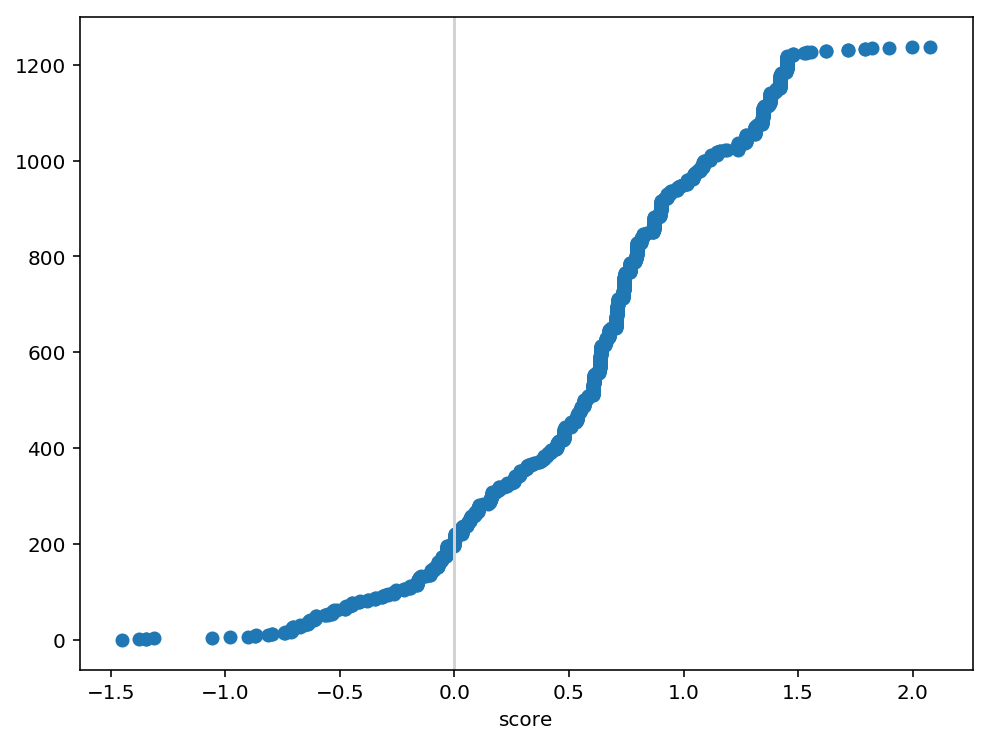

In [133]:
plt.figure(figsize=(8,6))
plt.scatter(x=df.score, y=df.index)
plt.xlabel('score')
plt.axvline(0, color='lightgrey')

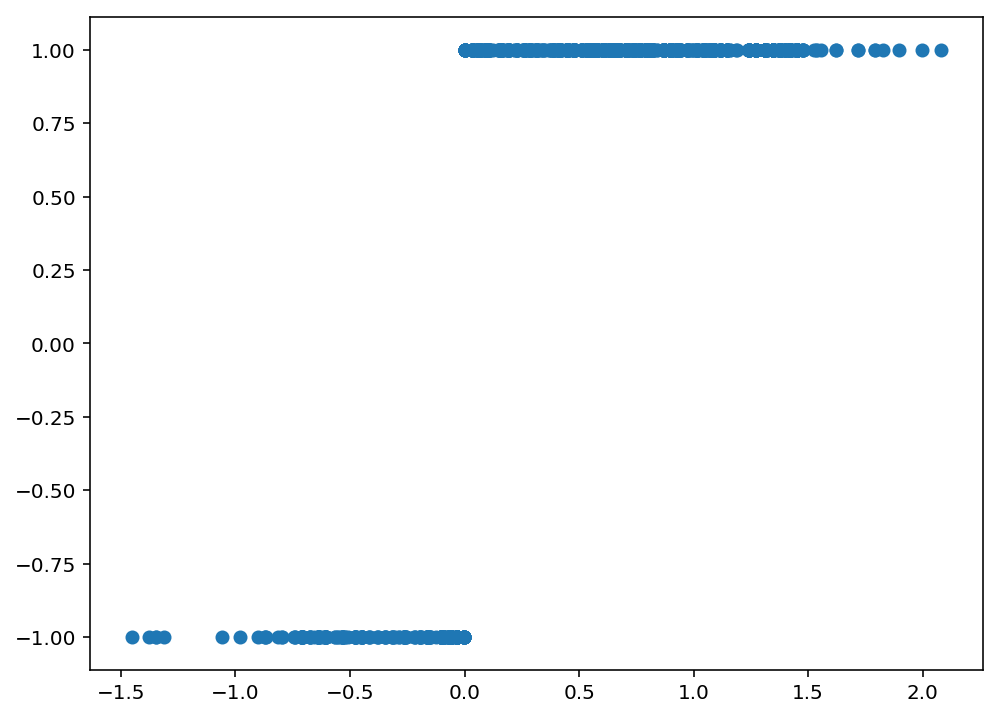

In [126]:
plt.figure(figsize=(8,6))
plt.scatter(x=df.score, y=df.pred)

/usr/local/anaconda3/envs/asp/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Text(0,0.5,'label/loss')

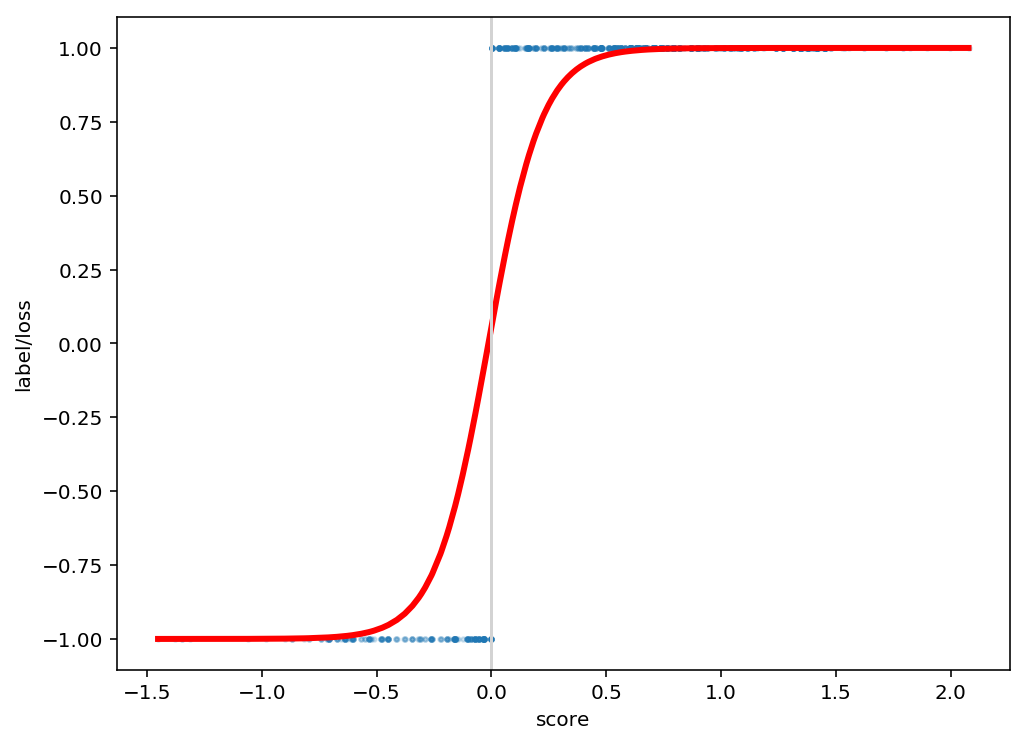

In [132]:
from sklearn.linear_model import LogisticRegression

score = df.score.values.reshape(len(df.score), 1)
pred = df.pred.values.reshape(len(df.pred), 1)

logreg = LogisticRegression()
logreg.fit(X=score, y=pred)

def model(x):
    return 2 / (1 + np.exp(-x)) - 1
loss = model(score * logreg.coef_ + logreg.intercept_).ravel()

plt.figure(figsize=(8,6))
plt.scatter(x=df.score, y=df.pred, alpha=0.2, s=5)
plt.plot(df.score, loss, color='red', linewidth=3)
plt.axvline(0, color='lightgrey')
plt.xlabel('score')
plt.ylabel('label/loss')